In [1]:

import pickle
import json
import sys
import re
import os
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim

# modules from the scikit-learn library
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# modules from the NLTK library
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import FreqDist
from nltk.tag import pos_tag_sents
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download(['vader_lexicon'])

c:\Users\jvand\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jvand\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# This notebook contains:
- the data exploration
- Support vector machine and random forest classifier experimentation
- Tf-idf and Word2Vec experimentation and training
- Parameter optimisation for the deep learning models
- Evaluation of deep learning models on the test data


In [4]:
# Method to load a data set
def loadDataset(directory_path: str, f_extension: str) -> list:
    load_files = [directory_path+ f for f in os.listdir(directory_path) if f.endswith(f_extension)]

    return load_files



In [5]:
# function that returns a merged pandas dataframe from a list of file names
def combineDataset(file_names: list, index_false=0, cols=None) ->  pd.core.frame.DataFrame:
    data = []
    for f in range(len(file_names)):
        if cols:
            df = pd.read_csv(file_names[f], usecols=cols)
        else:
            df = pd.read_csv(file_names[f])
        if f == index_false:
            df['target'] = 0
        else:
            df['target'] = 1
        
        data.append(df)
    
    return pd.concat(data)


The first step is to load the raw datafiles and combine them into a single dataframe

In [248]:
# Load and combine datasets

# load isot data
isot_data = loadDataset(directory_path='data/ISOT/', f_extension='.csv')
isot_data = combineDataset(file_names=isot_data, index_false=0, cols=['title', 'text', 'subject'])

# load fake or real dataset
fake_or_real_data = pd.read_csv('data/news_dataset_fake_or_real/news_datasets.csv', usecols=['title', 'text', 'label'])
fake_or_real_data['target'] = 0
fake_or_real_data.loc[(fake_or_real_data.label == 'REAL'), 'target'] = 1
fake_or_real_data.drop(columns=['label'], inplace=True)


# combine datasets
data = pd.concat([isot_data[['title', 'text', 'target']], fake_or_real_data])

# drop duplicate data
data.drop_duplicates(subset='text', inplace=True)

# reset index
data.reset_index(drop=True, inplace=True)

In [6]:
data = pd.read_csv('preprocessed_inter.csv')

# Data exploration

Before  conducting any type of machine learning and deep learning analysis, it is an excellent idea to get a better understanding of the data one is working with. I will achieve this by conducting some exploratory data analysis. This consists of showing:

- The data distribution
- Topics in the data: make frequency distribution of common words, plot data around those words
- After tokenisation and stop word removal, create a frequency distribution of common words or named entities
- Most useful text features, namely:
    - Frequency distribution of most common words
    - Emotive index/Polarity: calculated with the NLTK Vader sentiment analysis method
    - Coleman-Liau index/Readability: 0.0588 * L - 0..296 * S - 15.8 where L is the average number of letters per 100 words and S is the average number of sentences per 100 words.
    - Number of pronouns/Quantity feature


### Pre-process the data

- plot data distribution
- plot distribution of features among:
    - title
    - full text

The plot below will show the distribution between fake and real classes in the data

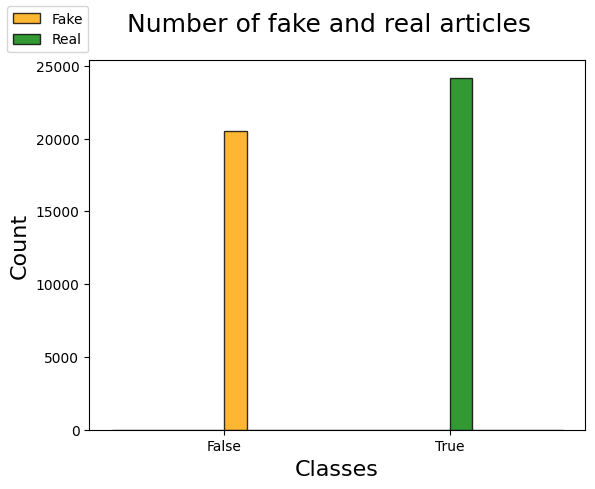

In [201]:
n_fake_articles = data.loc[(data.target == 0), 'target']
n_real_articles = data.loc[(data.target == 1), 'target']

fig, ax = plt.subplots()

ax.hist(n_fake_articles, color='orange', alpha=0.8, edgecolor='black', label='Fake')
ax.hist(n_real_articles, color='green', alpha=0.8, edgecolor='black', label='Real')
ax.set_xticks([0,1])
ax.set_xticklabels(['False', 'True'])

ax.set_xlabel('Classes', fontsize=16)
ax.set_ylabel('Count', fontsize=16)

fig.legend(loc='upper left')
fig.suptitle('Number of fake and real articles', fontsize=18)

fig.savefig('n_fake_real_articles.png')



# Calculating additional linguistic features

I am calculating additional linguistic features that are common in the field of nlp. These are:
- The Coleman-Liau Index
- The polarity scores
- The number of personal pronouns in the text

The polarity score is calculated using the NLTk SentimentIntensityAnalyzer. The other two are calculated using the custom functions defined below.

After removing stopwords from the text using the NLTK English stop word set. I plot the destribution of these linguistic features between the fake and real classes.

Once these values are calculated, distribution plots are created. These will indicate if there is any difference in distribution between the fake and real classes in terms of these metrics

In [28]:
# Get the compound polarity for all news titles
sia = SentimentIntensityAnalyzer()


In [1]:
def colemanLiauIndex(item):

    # list of words
    words = word_tokenize(item)
    #list of sentences
    sents = sent_tokenize(item)
    # number of words
    nWords = len(words) + 1
    # number of sentences
    nSents = len(sents)    
    # number of letters
    nLetters = pd.Series(words).apply(len).sum()
    
    # avg number of letters per 100 words
    L = nLetters / (nWords / 100)
    # avg number of sentences per 100 words
    S = nSents / (nWords / 100)
    # Return index
    return 0.0588 * L - 0.296 * S - 15.8 

In [7]:
def personalPronoun(item):
    if item == 'PRP' or item == 'PRP$':
        return 1
    else:
        return 0

In [8]:
def personalPronounCount(item):
    total = 0
    for k, v in item:
        total += personalPronoun(v)
    
    return total

In [434]:
# CALCULATE THE NUMBER OF PERSONAL PRONOUNS

# Get the number of personal pronouns per title. WARNING WILL RUN FOR A LONG TIME
data['title_pp'] = pd.Series(pos_tag_sents(data.title_processed.apply(word_tokenize).tolist())).apply(personalPronounCount)

# Get number of personal pronouns per text. WARNING THIS WILL RUN FOR A LONG TIME
data['text_nPP'] = pd.Series(pos_tag_sents(data.text_processed.apply(word_tokenize).tolist())).apply(personalPronounCount)


# CALCULATE THE TEXT POLARITY SCORES
# processed text polarity scores
data['text_polarity'] = data.text_processed.apply(sia.polarity_scores).apply(lambda x: x['compound'])

# processed title polarity scores
data['title_polarity'] = data.title_processed.apply(sia.polarity_scores).apply(lambda x: x['compound'])


# CALCULATE THE COLEMAN-LIAU INDEX

# processed titles Coleman Liau readability index scores
data['coleman_liau_title'] = data.title_processed.apply(colemanLiauIndex)

# processed text Coleman-Liau readibility index scores
data['coleman_liau_text'] = data.text_processed.apply(colemanLiauIndex)

In [45]:
stopword_cache = set(stopwords.words('english'))
def removeStopwords(item):
   return ' '.join([word for word in item if word not in stopword_cache])

In [62]:
# Remove stopwords from title
data['title_processed'] = data.title_processed.apply(word_tokenize).apply(removeStopwords)

In [64]:
# remove stopwords from text 
data['text_processed'] =data.text_processed.apply(word_tokenize).apply(removeStopwords)

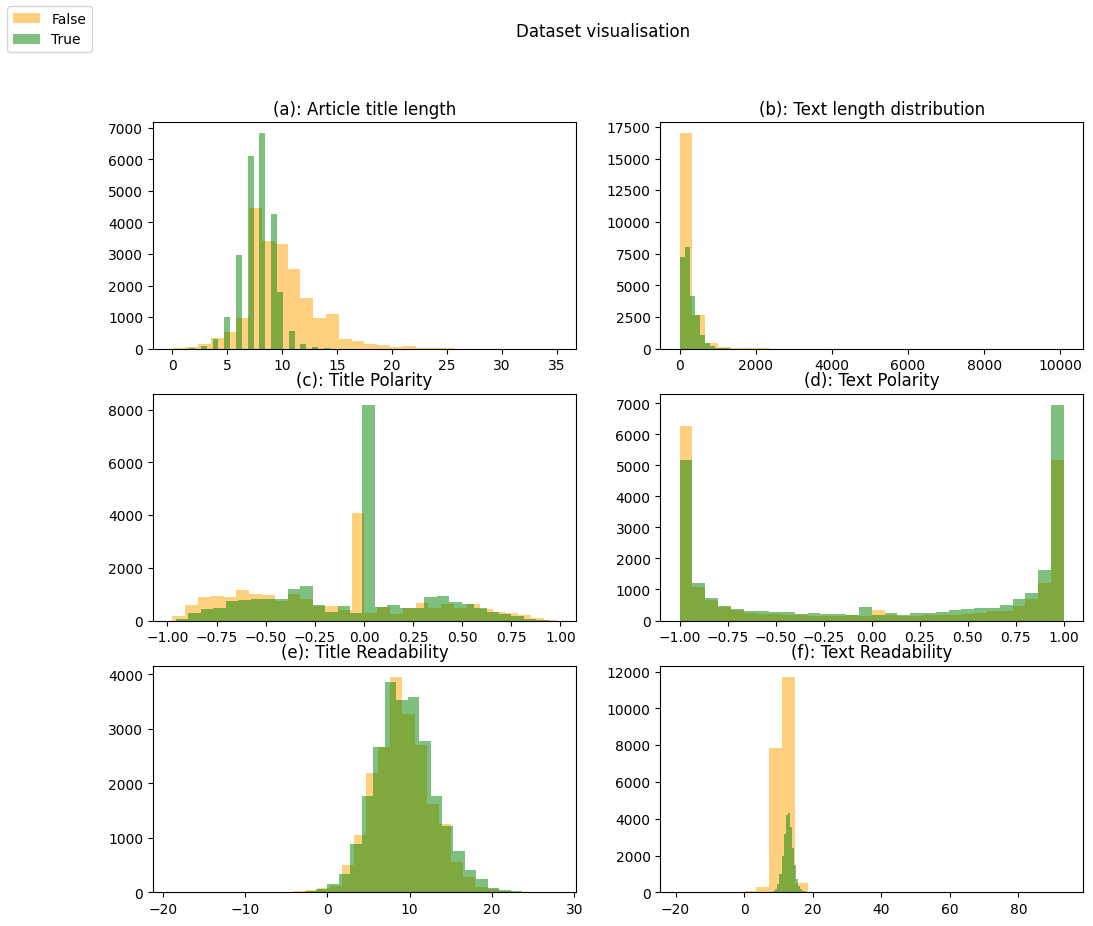

In [90]:
bins = 30

fig, axs = plt.subplots(nrows=3, ncols=2)

fig.set_size_inches(12, 10)



# get all title lengths in the separate classes
false_title_len = data.loc[(data.target == 0), 'title_processed'].apply(word_tokenize).apply(len)
true_title_len = data.loc[(data.target == 1), 'title_processed'].apply(word_tokenize).apply(len)

# # plot length of titles
axs[0][0].hist(false_title_len, bins=bins, alpha=0.5, color='orange', label='False')
axs[0][0].hist(true_title_len, bins=bins, alpha=0.5, color='green', label='True')

#axs[0][0].legend(loc='upper right')

axs[0][0].set_title('(a): Article title length')


# plot text lengths
false_txt_len = data.loc[(data.target == 0), 'text_processed'].apply(word_tokenize).apply(len)
true_txt_len = data.loc[(data.target == 1), 'text_processed'].apply(word_tokenize).apply(len)

axs[0][1].hist(false_txt_len, bins=bins, alpha=0.5, color='orange', label='False')
axs[0][1].hist(true_txt_len, bins=bins, alpha=0.5, color='green', label='True')
#axs[0][1].set_xticks([0,1,2,3,4,5,6,7])


axs[0][1].set_title('(b): Text length distribution')

# plot distribution of polarity
fake_polarity = data.loc[(data.target == 0), 'title_polarity']
real_polarity = data.loc[(data.target == 1), 'title_polarity']


axs[1][0].hist(fake_polarity, bins=bins, alpha=0.5, color='orange', label='Fake')
axs[1][0].hist(real_polarity, bins=bins, alpha=0.5, color='green', label='Real')

axs[1][0].set_title('(c): Title Polarity')

# plot distribution of polarity in text
fake_polarity_txt = data.loc[(data.target == 0), 'text_polarity']
real_polarity_txt = data.loc[(data.target == 1), 'text_polarity']


axs[1][1].hist(fake_polarity_txt, bins=bins, alpha=0.5, color='orange', label='Fake')
axs[1][1].hist(real_polarity_txt, bins=bins, alpha=0.5, color='green', label='Real')

axs[1][1].set_title('(d): Text Polarity')

# plot readability index
fake_readability = data.loc[(data.target == 0), 'coleman_liau_title']
real_readability = data.loc[(data.target == 1), 'coleman_liau_title']

axs[2][0].hist(fake_readability, bins=bins, alpha=0.5, color='orange', label='Fake')
axs[2][0].hist(real_readability, bins=bins, alpha=0.5, color='green', label='Real')

axs[2][0].set_title('(e): Title Readability')


# plot text readability index
cl_txt_fake = data.loc[(data.target == 0), 'coleman_liau_text']
cl_txt_real = data.loc[(data.target == 1), 'coleman_liau_text']
axs[2][1].hist(cl_txt_fake, bins=bins, alpha=0.5, color='orange', label='Fake')
axs[2][1].hist(cl_txt_real, bins=bins, alpha=0.5, color='green', label='Real')
axs[2][1].set_title('(f): Text Readability')


handles, labels = axs[0][0].get_legend_handles_labels()

fig.suptitle('Dataset visualisation')
fig.legend(handles, labels, loc='upper left')

fig.savefig('sixsubplots.png')





I will now create a frequency distribution of the 20 commonest words in across the fake and real classes. This is done for both the titles and the full texts.

In [153]:
fake_fdist_title = FreqDist()
for k, v in data.loc[(data.target == 0), 'title_processed'].str.split(' ').explode().value_counts().items():
    fake_fdist_title[k] = v

real_fdist_title = FreqDist()
for k, v in data.loc[(data.target == 1), 'title_processed'].str.split(' ').explode().value_counts().items():
    real_fdist_title[k] = v

In [178]:
# Initialise frequency distribution objects
fake_fdist_txt = FreqDist()
for k, v in data.loc[(data.target == 0), 'text_processed'].str.split(' ').explode().value_counts().items():
    fake_fdist_txt[k] = v


real_fdist_txt = FreqDist()
for k, v in data.loc[(data.target == 1), 'text_processed'].str.split(' ').explode().value_counts().items():
    real_fdist_txt[k] = v

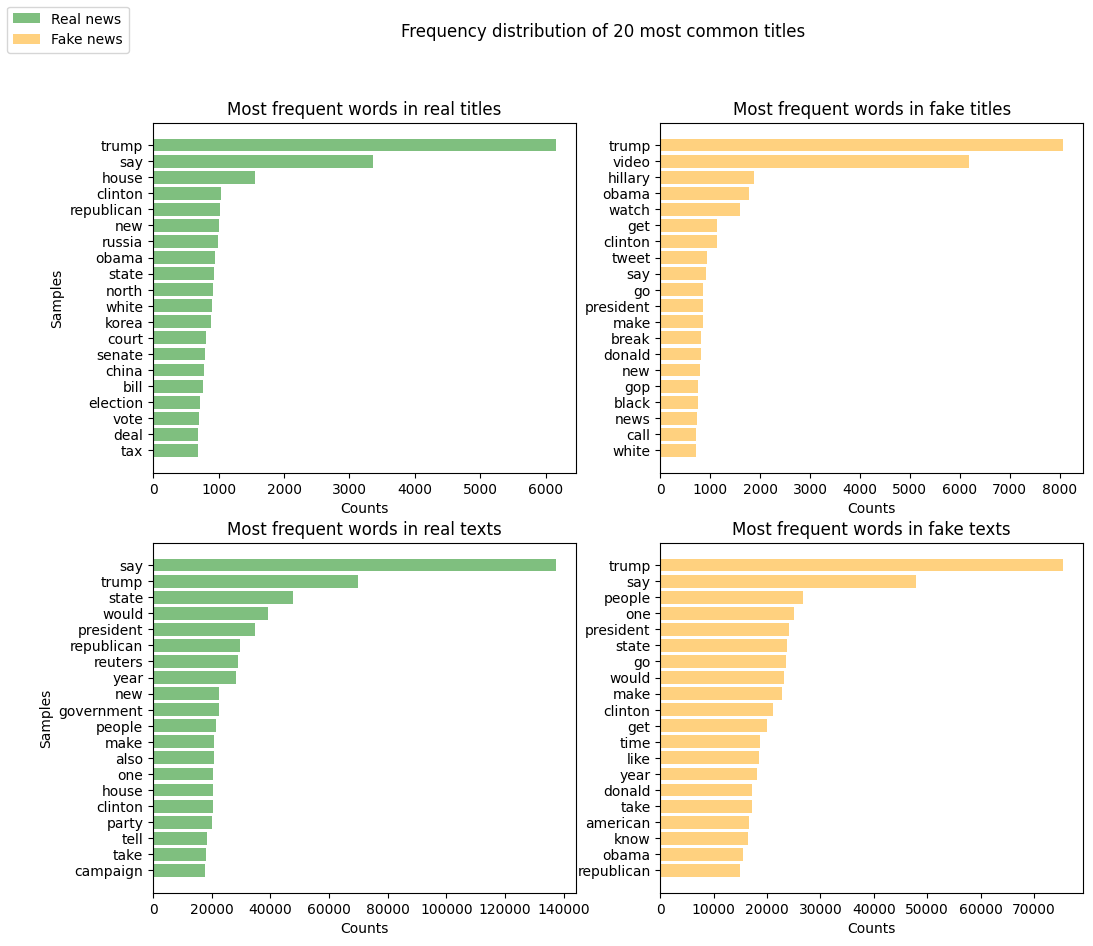

In [183]:
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)

fig.suptitle('Frequency distribution of 20 most common titles')


# REAL NEWS TITLES
# Plot swapped axes
x_rt = [v for k, v in sorted(real_fdist_title.most_common(20), key=lambda x: x[1])]
y_rt = [k for k, v in sorted(real_fdist_title.most_common(20), key=lambda x: x[1])]

axs[0][0].barh(y_rt, x_rt, color='green', alpha=0.5, label='Real news')
axs[0][0].set_xlabel('Counts')
axs[0][0].set_ylabel('Samples')
axs[0][0].set_title('Most frequent words in real titles')


# FAKE NEWS TITLES
# Plot swapped axes
x_ft = [v for k, v in sorted(fake_fdist_title.most_common(20), key=lambda x: x[1])]
y_ft = [k for k, v in sorted(fake_fdist_title.most_common(20), key=lambda x: x[1])]

axs[0][1].barh(y_ft, x_ft, color='orange', alpha=0.5, label='Fake news')
axs[0][1].set_xlabel('Counts')

axs[0][1].set_title('Most frequent words in fake titles')


# REAL NEWS TEXT
# Plot swapped axes
x_rtxt = [v for k, v in sorted(real_fdist_txt.most_common(20), key=lambda x: x[1])]
y_rtxt = [k for k, v in sorted(real_fdist_txt.most_common(20), key=lambda x: x[1])]

axs[1][0].barh(y_rtxt, x_rtxt, color='green', alpha=0.5, )
axs[1][0].set_xlabel('Counts')
axs[1][0].set_ylabel('Samples')
axs[1][0].set_title('Most frequent words in real texts')

# FAKE NEWS TEXT
# Plot swapped axes
x_ftxt = [v for k, v in sorted(fake_fdist_txt.most_common(20), key=lambda x: x[1])]
y_ftxt = [k for k, v in sorted(fake_fdist_txt.most_common(20), key=lambda x: x[1])]

axs[1][1].barh(y_ftxt, x_ftxt, color='orange', alpha=0.5,)
axs[1][1].set_xlabel('Counts')

axs[1][1].set_title('Most frequent words in fake texts')


fig.legend(loc='upper left')

fig.savefig('frequencydist.png')


# Data preprocessing

In the data pre-processing stage I will do the following:
- remove single characters
- Remove non-alphabetical charactes
- create a lemmatised copy of the data
- in order to carry out the lemmatisation process properly, is provide each word with a part-of-speech tag using the custom methods below.

Once the titles and full texts are pre-processed. I create a combination of the title and the first 200 words of the full text. This is the third input size that is evaluated.


In [13]:
# ensure reproducibility
np.random.seed(100)

In [12]:
def tagger(i):
    pos_tags = {
    'J': wn.ADJ,
    'V': wn.VERB,
    'R': wn.ADV,
    'N': wn.NOUN
    }
    try:
        ans = pos_tags[i]
        return ans
    except:
        return None

In [13]:
def makeLemma(word, tag):
    # word lemmatiser
    word_lemmatiser = WordNetLemmatizer()

    
    if tag:
        
        return word_lemmatiser.lemmatize(word, tag)
    else:
        
        return word_lemmatiser.lemmatize(word)

In [4]:
def progress(count:int, total:int, suffix='') -> None:

        progress_bar_length = 100

        current_length = int(round(progress_bar_length * count / float(total)))

        pct = round(100 * count / float(total), 1)
        
        bar = '=' * current_length + '-' * (progress_bar_length - current_length)
        
        sys.stdout.write('[%s] %s%s ...%s\r' %(bar, pct, '%', suffix))

        sys.stdout.flush()
        return

In [5]:
def removeSingleChars(input):
    return ' '.join( [w for w in input.split() if len(w)>1] )

In [6]:
def preProcess(data: pd.Series, applyLemmatisation: bool):

    d = data.apply(str.lower)

     
    
    
    # replace non-alphabetical characters with empty strings
    # things like numbers, interpunction and white spaces
    d = [re.sub(r'\d+', '', re.sub(r'\W+', ' ', txt)) for txt in d]

    d = pd.Series(d)

    if not applyLemmatisation:
        return d

    # Tokenise and run initial pos tagger on data
    d = pos_tag_sents(d.apply(word_tokenize).tolist())
    
    lemmatised_txts = []

    for i in range(len(d)):
        progress(count=i, total=len(d))
        txt = d[i]

        tagged_txt = list(map(lambda item: (item[0], tagger(item[1][0])), txt))

        lemmatised_txt = [makeLemma(w, tag) for w, tag in tagged_txt]
        lemmatised_txts.append(lemmatised_txt)
    return pd.Series(lemmatised_txts).apply(' '.join)

In [256]:
 # PREPROCESS WITH LEMMATISATION
# preprocess all title data
data['title_processed'] = preProcess(data.title, applyLemmatisation=True).apply(removeSingleChars)

# pre process all text data WARNING THIS WILL RUN FOR A LONG TIME
data['text_processed'] = preProcess(data.text, applyLemmatisation=True).apply(removeSingleChars)


# PREPROCESS WITHOUT LEMMATISATION
# preprocess titles w/o lemmatisation
data['title_no_lemma'] = preProcess(data.title, applyLemmatisation=False).apply(removeSingleChars)

# preprocess texts w/o lemmatisation
data['text_no_lemma'] = preProcess(data.text, applyLemmatisation=False).apply(removeSingleChars)


# CREATE TITLE AND TEXT COMBINATION OF 200 WORDS OF TEXT
# Might run for a long time
# UNLEMMATISED
data['title_text_no_lemma'] = data.title_no_lemma + data.text_no_lemma.apply(word_tokenize).apply(lambda x: x[:200]).apply(lambda x: ' '.join(x))

# LEMMATISED
data['title_text_lemma'] = data.title_processed + data.text_processed.apply(word_tokenize).apply(lambda x: x[:200]).apply(lambda x: ' '.join(x))

In [20]:
# save data 
data.to_csv('preprocessedfinished.csv')

In [5]:
# load data
data = pd.read_csv('preprocessedfinished.csv')
cols = ['title_processed', 'title_polarity', 'coleman_liau_title', 'title_pp', 'target']


# Setting up the baseline

I want to do evaluate the performance of several classifiers, across different amount of texts using a variety of text representation techniques. The text representation techniques are:
- TF-IDF, word2vec and BERT

I evaluate these representations by training classifiers on only the title of an article, the title and the first 200 words of an article, and the full text. In each case a baseline needs to be set up. The baseline performance is set up by taking a look at the literature. There a baseline is found by using TF-IDF, no lemmatisation/stemming, no other features, a max vocabulary of 10000 words. 

Each algorithm is supplied with some parameters for a baseline. 
- SVM
    -- kernel 'RBF', 'C': 1e3, 'kernel coefficient gamma': 1
- RF
    -- 500 trees and a maximum number of features of 50

Then:
- lemmatisation and no additional features
- lemmatisation and additional features suggested from literature review

title: no lemma, lemma, no lemma + features, lemma + features

text: no lemma, lemma, no lemma + features, lemma + features

title + text: no lemma, lemma, no lemma + features, lemma + features


baseline:
parameters from paper
no lemma
title, text, text + title

first experiment:
parameters from paper
lemma + no lemma
other features
title, text, text + title

select best performing combination for title, text and text + title:
then explore other parameters for that combination.

then train on all train data and test a final time. save model.

when training and testing the final time, be sure to save each trained model for later


The data is split in a training and test set. This is done using the train_test_split method from scikit-learn. The test size is always 30%. A random_state variable is initialised to 4578,
This means that across iterations the same data is split. I.e. all models will be trained and evaluated on the same samples to ease comparison across classifiers. The training data is further split in a training and validation set. This is done using stratified k-fold cross validation. 5 separate folds are used.

# Columns with the name 'processed' refer to lemmatised data
# i.e. title_processed and text_processed are the lemmatised titles and full texts respectively

In [ ]:
# results dictionary
baseline = {}


In [2]:
# define the models with parameter settings
models = [SVC(kernel='rbf', C=1e3, gamma=1), RandomForestClassifier(n_estimators=500, max_features=50)]
maxfeatures = 10000
randomState = 4578

# define the metrics
metrics = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc']

In [89]:
def makeBaseline(colname: str):

    baseline[colname] = {}

    # split data into training and testing
    # 30 percent is for testing and 70 for training
    train_x, test_x, train_y, test_y = train_test_split(data[colname], data.target, test_size=0.3, random_state=randomState)

    # this is a classifier object, can be reused with other algorithms and configurations at a later stage
    # stratified k fold is used in the cros-validate method as the estimator is a classifier and y is binary class. 

    for model in models:
    
        clf = make_pipeline(TfidfVectorizer(max_features=maxfeatures), model)
        modelName = clf.steps[-1][0]
        
        # add scores dictionary to dictionary of models
        baseline[colname][modelName] = cross_validate(clf, train_x, train_y, scoring=metrics, cv=5, n_jobs=-1, verbose=2, return_train_score=False)
        
    


In [116]:
# Set baseline for svm and rf with no lemmatisation and do first experiment with lemmatisation
experiments = ['title_no_lemma', 'title_text_no_lemma', 'title_text_lemma', 'text_no_lemma', 'title_processed', 'text_processed']

for experiment in experiments:    
    makeBaseline(experiment)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 19.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 19.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


In [ ]:
first_experiment= {}

In [202]:
def firstExperiment(colname: str, cols: list):
    vectorizer = TfidfVectorizer(max_features=maxfeatures)
    first_experiment[colname] = {}

    features = cols
    features.append(colname)
    
    # split data into training and testing
    # 30 percent is for testing and 70 for training
    train_x, test_x, train_y, test_y = train_test_split(data[features], data.target, test_size=0.3, random_state=randomState)
    for model in models:
        column_transformer = ColumnTransformer(
            [('tfidf1', vectorizer, colname)],
            remainder='passthrough'
        )

        clf = make_pipeline(column_transformer, model)
        # store the model name
        modelName = clf.steps[-1][0]

        # add scores to the dictionary of results
        first_experiment[colname][modelName] = cross_validate(clf, train_x, train_y, scoring=metrics, cv=5, n_jobs=-1, return_train_score=False)

In [203]:
# SOMETIMES THE INTERPRETER THROWS AN ERROR WHEN CONDUCTING MULTIPLE EXPERIMENTS CONSECUTIVELY
# in this case: just run one experiment at a time.
# e.g. first_experiments = ['title_no_lemma']
titlecols = [ 'title_polarity', 'title_pp', 'coleman_liau_title']
title_first_experiments = ['title_no_lemma', 'title_processed', 'title_text_no_lemma', 'title_text_lemma']


for experiment in title_first_experiments:
    firstExperiment(colname=experiment, cols=titlecols)

# SOMETIMES THE INTERPRETER THROWS AN ERROR WHEN CONDUCTING MULTIPLE EXPERIMENTS CONSECUTIVELY
# in this case: just run one experiment at a time.
# e.g. text_first_experiments = ['text_polarity']
textcols = ['text_polarity', 'coleman_liau_text', 'text_nPP']
text_first_experiments = ['text_processed', 'text_no_lemma']

for exp in text_first_experiments:
    firstExperiment(colname=exp, cols=textcols)


## intermediary.csv is the final pre-processed dataset.

In [3]:
data = pd.read_csv('intermediary.csv')

# Experiment 2: training and evaluating the algorithms using *word2vec*

I begin by creating my own embedding. A unique embedding is needed for the preprocessed titles, texts and title and text combinations. Since my model cannot have seen the testing data when creating the embedding, I first split the data.


#

In [5]:
# split data into training and testing
# 30 percent is for testing and 70 for training
# x is all columns apart from raw data and the target column
# y is the target column
train_x, test_x, train_y, test_y = train_test_split(data.iloc[:,3:], data.target, test_size=0.3, random_state=randomState)

In [10]:
# Create separate embeddings for the titles, texts, and title-text combinations. 

# title
wv_title_lem = gensim.models.Word2Vec(train_x.title_processed.apply(word_tokenize), vector_size=100, min_count=1)
wv_title_no_lem = gensim.models.Word2Vec(train_x.title_no_lemma.apply(word_tokenize), vector_size=100, min_count=1)

# text
wv_text_lem = gensim.models.Word2Vec(train_x.text_processed.apply(word_tokenize), vector_size=100, min_count=1)
wv_text_no_lem = gensim.models.Word2Vec(train_x.text_no_lemma.apply(word_tokenize), vector_size=100, min_count=1)

# title-text
wv_tit_txt_lem = gensim.models.Word2Vec(train_x.title_text_lemma.apply(word_tokenize), vector_size=100, min_count=1)
wv_tit_txt_no_lem = gensim.models.Word2Vec(train_x.title_text_no_lemma.apply(word_tokenize), vector_size=100, min_count=1)

In [11]:
# save a word2vec embedding
#wv_title_lem.wv.save_word2vec_format('wv_title_lem.bin')
# wv_title_no_lem.wv.save_word2vec_format('wv_title_no_lem.bin')
# wv_title_no_lem.wv.save_word2vec_format('wv_title_no_lem')

# title text embeddings
wv_tit_txt_lem.save('wv_tit_txt_lem.model')
wv_tit_txt_no_lem.save('wv_tit_txt_no_lem.model')

# text embeddings
wv_text_lem.save('wv_text_lem.model')
wv_text_no_lem.save('wv_text_no_lem.model')

In [12]:
# Creat a class that makes vectors of equal length of a word2vec embedding
class Wv2Sequence():
    def __init__(self, embedding: gensim.models.keyedvectors.KeyedVectors, vocab: set, sequenceLength: int):
        self.embedding = embedding
        self.sequenceLength = sequenceLength
        self.vocab = vocab
    
    
    def getvectors(self, txt):
        # This method returns the Word2Vec vector for a 
        #  sequence of words in a text
        # if the words exist in the embedding
        output = []
        for word in txt:
            if word in self.vocab:
                output.append(self.embedding[word])
            else:
                pass
        return np.asarray(output)
    
    def txtToSequence(self, txt: str | pd.core.series.Series):
        if type(txt) == str:
            txt = pd.Series(txt)
        
        # Tokenise the input, get vectors for all words in vocabulary, remove unknown words
        # convert to numpy array and concatenate
        text_vector =  np.concatenate(np.asarray(txt.apply(word_tokenize).apply(self.getvectors).dropna()), axis=None)
        

        
        if len(text_vector) < self.sequenceLength:
            # if the length of the vector is shorter than the max length, pad the vector with additional zeroes
            diff = self.sequenceLength - len(text_vector)
            return np.concatenate((text_vector, np.zeros(diff)), axis=None)
        else:
            # if the vector is longer than allowed, or equal
            # I return the maximum number of tokens
            return text_vector[:self.sequenceLength]
    
    @staticmethod
    def conductPCA(vector: np.ndarray, name:str, n_comp: list) -> None:
        # conduct principal component analysis for the current word2vec embedding
        for n in n_comp:
            pca = PCA(n_components=n)
            pca.fit(vector)
            print(name, 'Variance explained with {n} components:'.format(n=n), sum(pca.explained_variance_ratio_))
    
    @staticmethod
    def reformatVector(n_components: int, vector: np.ndarray) -> np.ndarray:
        pca = PCA(n_components=n_components)


        pca.fit(vector)
        return pca.transform(vector)


        


In [13]:
embeddings = ['wv_title_lem.bin']

# Creat a sequence for title
title_sequence = Wv2Sequence(embedding=wv_title_lem.wv, vocab=set(wv_title_lem.wv.index_to_key), sequenceLength=1000)
title_sequence_no_lemma = Wv2Sequence(embedding=wv_title_no_lem.wv, vocab=set(wv_title_no_lem.wv.index_to_key), sequenceLength=1000)

# sequence for title + text
tit_txt_lem_seq = Wv2Sequence(embedding=wv_tit_txt_lem.wv, vocab=set(wv_tit_txt_lem.wv.index_to_key), sequenceLength=1000)
tit_txt_seq = Wv2Sequence(embedding=wv_tit_txt_no_lem.wv, vocab=set(wv_tit_txt_no_lem.wv.index_to_key), sequenceLength=1000)

# sequence for text
txt_lem_seq = Wv2Sequence(embedding=wv_text_lem.wv, vocab=set(wv_text_lem.wv.index_to_key), sequenceLength=1000)
txt_no_lem_seq = Wv2Sequence(embedding=wv_text_no_lem.wv, vocab=set(wv_text_no_lem.wv.index_to_key), sequenceLength=1000)

In [14]:
# convert training x data to vectors
train_x_vector = np.array(train_x.title_processed.apply(title_sequence.txtToSequence).tolist())
train_x_title_no_lemma = np.array(train_x.title_no_lemma.apply(title_sequence_no_lemma.txtToSequence).tolist())



# title + txt with lemma and no lemma
train_x_tit_text_lem = np.array(train_x.title_text_lemma.apply(tit_txt_lem_seq.txtToSequence).tolist())
train_x_tit_text = np.array(train_x.title_text_no_lemma.apply(tit_txt_seq.txtToSequence).tolist())

# text with lemma and no lemma
train_x_txt_lem = np.array(train_x.text_processed.apply(txt_lem_seq.txtToSequence).tolist())
train_x_txt_no_lem = np.array(train_x.text_no_lemma.apply(txt_no_lem_seq.txtToSequence).tolist())

### a Sequencer and an embedding have been created

Each vector has a 1000 dimensions. Lets see if it is possible to reduce the number of dimensions and thus speed up the training process of the SVC and RF.
The cell below shows that with merely a 150 features more than 99% of the variance can be explained. So I will reformat the vectors to only include 150 features in the case of the titles. 
For the full text and title and text combinations 900 features are used, because this explains the highest level of variance according to the principal component analysis.

In [309]:
# conduct principal component analysis to find the vector dimensionality that explains the variance well
title_sequence.conductPCA(train_x_vector, 'title_text', n_comp=[10,50,100,150,200,500])


Variance explained with 10 components: 0.4834727061202252
Variance explained with 50 components: 0.8909674818947819
Variance explained with 100 components: 0.9728365669836249
Variance explained with 150 components: 0.9910729706478808
Variance explained with 200 components: 0.9959835697962441
Variance explained with 500 components: 0.9995518999272862


In [25]:
tit_txt_seq.conductPCA(train_x_tit_text, 'title+text',n_comp = [200, 500,700,800,900])
tit_txt_lem_seq.conductPCA(train_x_tit_text_lem, 'title+text+lemma',n_comp = [200, 500,700,800,900])

title+text Variance explained with 200 components: 0.6432071315357462
title+text Variance explained with 500 components: 0.8758153296075761
title+text Variance explained with 700 components: 0.9477778908476466
title+text Variance explained with 800 components: 0.9721950485545676
title+text Variance explained with 900 components: 0.9891475721233292
title+text+lemma Variance explained with 200 components: 0.6620007844156199
title+text+lemma Variance explained with 500 components: 0.8676487857574081
title+text+lemma Variance explained with 700 components: 0.9400107278175819
title+text+lemma Variance explained with 800 components: 0.9670962576317521
title+text+lemma Variance explained with 900 components: 0.9865324020413246


In [29]:
# the best trade off between bias and variance is 900 components. so reformat the vectors.
train_x_tit_text = tit_txt_seq.reformatVector(n_components=900, vector=train_x_tit_text)
train_x_tit_text_lem = tit_txt_lem_seq.reformatVector(n_components=900, vector=train_x_tit_text_lem)


In [15]:
# conduct pca for the texts then reformat vectors
txt_lem_seq.conductPCA(train_x_txt_lem, 'text lemma',n_comp = [200, 500,700,800,900])
txt_no_lem_seq.conductPCA(train_x_txt_no_lem, 'text no lemma',n_comp = [200, 500,700,800,900])


text lemma Variance explained with 200 components: 0.6379326427170179
text lemma Variance explained with 500 components: 0.8519898919775294
text lemma Variance explained with 700 components: 0.9316732304101148
text lemma Variance explained with 800 components: 0.9632410452614386
text lemma Variance explained with 900 components: 0.9863386506003927
text no lemma Variance explained with 200 components: 0.6603709773159577
text no lemma Variance explained with 500 components: 0.8699203402916205
text no lemma Variance explained with 700 components: 0.942591802640539
text no lemma Variance explained with 800 components: 0.9699019729366114
text no lemma Variance explained with 900 components: 0.9894514503460533


In [16]:
# best score was with 900 components out of a max of thousand so that is what I pick
train_x_txt_lem = txt_lem_seq.reformatVector(n_components=900, vector=train_x_txt_lem)

train_x_txt_no_lem = txt_no_lem_seq.reformatVector(n_components=900, vector=train_x_txt_no_lem)

In [380]:
pca = PCA(n_components=150)
# pca.fit(train_x_vector)
# train_x_vector = pca.transform(train_x_vector)
pca.fit(train_x_title_no_lemma)
train_x_title_no_lemma = pca.transform(train_x_title_no_lemma)

In [315]:
pd.DataFrame(train_x_vector).to_csv('title_lemma_w2v_processed.csv')

## Training the models using the Word2vec embedding

I now create a custom function to train and evaluate the support vector machine and random forest classifier using the Word2Vec text representation.
Cross-validation is used again. So a validation dataset is set aside from the training data. The results are stored in a dictionary.

This is done for the lemmatised and unlemmatised data, in conjunction with and without the linguistic features.
So the titles are evaluated a total of four times, and the same goes for the full texts and the titles and texts.

In [17]:
# train the rf and svc models and store scores
def evalW2V(data_x, data_y,mapping: dict, name: str):
    mapping[name] = {}
    for model in models:
    
        
        modelName = type(model).__name__
        
        # add scores dictionary to dictionary of models
        mapping[name][modelName] = cross_validate(model, data_x, data_y, scoring=metrics, cv=2, n_jobs=-1, verbose=1, return_train_score=False)

In [18]:
w2v_results = {}

In [335]:
# Train and evaluate the lemmatised titles
# with and without linguistic features
evalW2V(data_x=train_x_vector, data_y=train_y, mapping=w2v_results, name='title_processed')
evalW2V(data_x=np.concatenate((train_x_vector,train_x.iloc[:,1:4].to_numpy()), axis=1), data_y=train_y, mapping=w2v_results, name='title_processed_features')

# train and evaluate the unlemmatised titles
# with and without linguistic features
evalW2V(data_x=train_x_title_no_lemma, data_y=train_y, mapping=w2v_results, name='title_no_lemma')
evalW2V(data_x=np.concatenate((train_x_title_no_lemma,train_x.iloc[:,1:4].to_numpy()), axis=1), data_y=train_y, mapping=w2v_results, name='title_no_lemma_features')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 23.8min finished


In [33]:
# train and evaluate the lemmatised and unlemmatised title and text combination
evalW2V(data_x=train_x_tit_text, data_y=train_y, mapping=w2v_results, name='tit_txt_no_lemma')
evalW2V(data_x=train_x_tit_text_lem, data_y=train_y, mapping=w2v_results, name='tit_txt_lemma')

# train and evaluate the lemmatised and unlemmatised title and text combination
# with additional linguistic features
evalW2V(data_x=np.concatenate((train_x_tit_text,train_x.iloc[:,5:8].to_numpy()), axis=1), data_y=train_y, mapping=w2v_results, name='tit_txt_no_lemma_features')
evalW2V(data_x=np.concatenate((train_x_tit_text_lem,train_x.iloc[:,5:8].to_numpy()), axis=1), data_y=train_y, mapping=w2v_results, name='tit_txt_lemma_features')
pd.DataFrame(w2v_results).to_csv('w2v_tit_txt2.csv')
#pd.DataFrame(w2v_results).to_csv('w2v_tit_txt.csv')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 18.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 14.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 18.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 16.7min finished


In [22]:
# train and evaluate all texts vectors

# no features lemma optional
evalW2V(data_x=train_x_txt_lem, data_y=train_y, mapping=w2v_results, name='full_txt_lemma')
evalW2V(data_x=train_x_txt_no_lem, data_y=train_y, mapping=w2v_results, name='full_txt_no_lemma')

# features lemma optional
evalW2V(data_x=np.concatenate((train_x_txt_lem,train_x.iloc[:,9:12].to_numpy()), axis=1), data_y=train_y, mapping=w2v_results, name='full_txt_no_lemma_features')
evalW2V(data_x=np.concatenate((train_x_txt_no_lem,train_x.iloc[:,9:12].to_numpy()), axis=1), data_y=train_y, mapping=w2v_results, name='full_txt_lemma_features')

# save results
pd.DataFrame(w2v_results).to_csv('w2v_full_text1.csv')

# store results again
pd.DataFrame(w2v_results).to_csv('w2v_tit_txt3.csv')
pd.DataFrame(w2v_results).to_csv('w2v_title.csv')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 18.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 16.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 15.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 16.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 17.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed: 15.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out

# Evaluation of experiment 1 and 2

A baseline has been set. Experiment 1, using tf-idf, and experiment 2, using word2vec, have been conducted. I will now show the results in a table, to determine what the best combination of features and text representation is. This is judged on accuracy. Once I know what the optimal combination is, I can it to further explore the parameter settings in the following section.

### data formatting

The results have been stored in dictionaries. I converted them to dataframes, but this made strings of the numpy arrays. I now need to do some formatting and conversion to be able to appropriately use them and restore these strings to the arrays they originally were.

In [2]:
def clfDataToJSON(data: str) -> dict:

    # replace: newline character, array(, ) with empty string, and switch single quotes
    # return dictionary
    return json.loads(data.replace('\n', '').replace('array(', '').replace(')', '').replace("'", '"'))

In [60]:
def jsonToDataframe(filename:str, cols: list, features: bool, txt_represent: str) -> pd.DataFrame:
    # instantiate a result dictionary
    res = {}
    res['svc'] = {}
    res['randomforestclassifier'] = {}
    data = pd.read_csv(filename)
    
    # for all columns that I am interested in, get the data and format it using the string replace techniques
    # store the results in the dictionary
    for col in cols:
        res['svc'][col] = clfDataToJSON(data[:1][col].to_dict()[0])
        res['randomforestclassifier'][col] = clfDataToJSON(data[1:][col].to_dict()[1])
    
    # make dataframes from the results and join them
    svc_df = pd.DataFrame.from_dict(res['svc'])#
    rf_df = pd.DataFrame.from_dict(res['randomforestclassifier'])#
    svc_df['classifier'] = 'SVC'
    rf_df['classifier'] = 'randomforestclassifier'
    combined = pd.concat((svc_df, rf_df)).reset_index()

    # add the feature value, this specifies whether the linguistic features have been applied or not
    combined['features'] = features

    # add the text representation technique
    combined['technique'] = txt_represent

    # calculate the mean scores of the columns
    # combine with the other columns to return the dataframe in a better format
    combined = pd.concat((combined[['classifier', 'technique', 'features', 'index']],combined.iloc[:,1:7].map(np.mean)), axis=1)

    # rename some odd  column names
    combined.rename(columns={'index':'metrics', 'title_processed': 'title_lemma', 'text_processed': 'text_lemma'}, inplace=True)

    



    return combined

In [61]:

cols = ['title_no_lemma', 'text_no_lemma', 'title_processed', 'text_processed', 'title_text_no_lemma', 'title_text_lemma']

# baseline experiments are:
# tf-idf, no lemmatisation, no features
# title_no_lemma, text_no_lemma title_text_no_lemma
base_and_exp1 = jsonToDataframe(filename='baseline.csv', cols=cols, features=False, txt_represent='tf-idf')

# first experiments are:
# tf-idf, lemmatisation (optional), features
exp1_features = jsonToDataframe(filename='firstexperiment2.csv', cols=cols, features=True, txt_represent='tf-idf')



#pd.DataFrame(clfDataToJSON(baseline[:1]['title_no_lemma'].to_dict()[0]))

In [82]:
# the word2vec data has been stored in a different manner. The dictionary is represented differently so it needs its own method
def formatWord2vecPandas(df: str, cols: list, txt_technique: str) -> pd.DataFrame:
    res = {}
    res['svc'] = {}
    res['randomforestclassifier'] = {}
    data = pd.read_csv(df)

    for col in cols:
        res['svc'][col] = clfDataToJSON(data[col].to_dict()[0])
        res['randomforestclassifier'][col] = clfDataToJSON(data[col].to_dict()[1])
    svc_df = pd.DataFrame.from_dict(res['svc'])#
    rf_df = pd.DataFrame.from_dict(res['randomforestclassifier'])#
    svc_df['classifier'] = 'SVC'
    rf_df['classifier'] = 'randomforestclassifier'
    combined = pd.concat((svc_df, rf_df)).reset_index()

    combined['technique'] = txt_technique
    
    # calculate the mean of the array columns, re-order the columns
    combined = pd.concat((combined[['classifier', 'technique', 'index']],combined.iloc[:,1:5].map(np.mean)), axis=1)

    combined.rename(columns={'index': 'metrics'}, inplace=True)

    return combined

In [83]:
# Now get the results of experiment 2: the word2vec representation
w2v_files = {'w2v_title.csv':['title_processed',	'title_processed_features',	'title_no_lemma',	'title_no_lemma_features'], 
'w2v_tit_txt3.csv': [ 'tit_txt_no_lemma',	'tit_txt_lemma',	'tit_txt_no_lemma_features',	'tit_txt_lemma_features',],
'w2v_full_text1.csv': [ 'full_txt_lemma',	'full_txt_no_lemma',	'full_txt_no_lemma_features',	'full_txt_lemma_features']}

# this list will contain dataframes of the word2vec results
w2v_data = []
for k, v in enumerate(w2v_files):
    w2v_data.append(formatWord2vecPandas(v, w2v_files[v], txt_technique='word2vec'))

In [121]:
# rename some columns for better comprehension
w2v_data[0].rename(columns={'title_processed':'title_lemma', 'title_processed_features': 'title_lemma_features'}, inplace=True)

# Evaluation of results

# The cell below shows the results of the baseline and experiment 1 and 2 in a series of tables


what is interesting is that it shows that when it comes to tf-idf
the support vector machine with no lemmatisation and no additional features performs the best
in all three experiments: title, title and text, full text

the accuracy scores are the mean results of the stratified k-fold cross validation

when it comes to word2vec the random forest classifier with lemmatisation and addtional features performs the best in all three 
experiments: title, title and text, full text

my reasoning for this: tf-idf has already a lot of features, these are not that intelligble or helpful. less features is more. in this case
the word2vec embedding is not very useful and may be too small. the adiditonal features help in this instance.


the random forest classifier of tf-idf outperforms the random forest classifier trained with word2vec
I will conduct a parameter optimisation grid search
with tf-idf, and test both classifiers. Eachwill then be trained and tested a final time

In [122]:

# SHOW THE RESULTS OF THE BASELINE AND EXPERIMENT 1 AND 2
print('SHOW THE RESULTS OF THE BASELINE AND EXPERIMENT 1 IN A DATAFRAME')
# show the baseline scores and those of experiment 1
display(pd.concat((base_and_exp1.loc[(base_and_exp1.metrics == 'test_accuracy')],exp1_features.loc[(exp1_features.metrics == 'test_accuracy')])))

print('=================================================================\n')
print('SHOW THE RESULTS OF EXPERIMENT 2 IN A DATAFRAME\n')

print('THESE ARE THE RESULTS OF THE EXPERIMENT ON THE TITLE\n')
display(w2v_data[0].loc[(w2v_data[0].metrics == 'test_accuracy')])

print('\n\n')
print('THESE ARE THE RESULTS OF THE EXPERIMENT ON THE TITLE AND FIRST 200 WORDS OF THE ARTICLE\n')
display(w2v_data[1].loc[(w2v_data[1].metrics == 'test_accuracy')])



print('\n\n')
print('THESE ARE THE RESULTS OF THE EXPERIMENT ON THE FULL TEXT\n')
display(w2v_data[2].loc[(w2v_data[2].metrics == 'test_accuracy')])


SHOW THE RESULTS OF THE BASELINE AND EXPERIMENT 1 IN A DATAFRAME


,classifier,technique,features,metrics,title_no_lemma,text_no_lemma,title_lemma,text_lemma,title_text_no_lemma,title_text_lemma
2,SVC,tf-idf,False,test_accuracy,0.910767,0.970149,0.900156,0.968519,0.953913,0.955863
9,randomforestclassifier,tf-idf,False,test_accuracy,0.896801,0.950494,0.886701,0.951868,0.933491,0.937166
2,SVC,tf-idf,True,test_accuracy,0.862284,0.828885,0.850395,0.814280,0.915785,0.916552
9,randomforestclassifier,tf-idf,True,test_accuracy,0.894819,0.948960,0.889162,0.950973,0.934737,0.937870



SHOW THE RESULTS OF EXPERIMENT 2 IN A DATAFRAME

THESE ARE THE RESULTS OF THE EXPERIMENT ON THE TITLE



,classifier,technique,metrics,title_lemma,title_lemma_features,title_no_lemma,title_no_lemma_features
2,SVC,word2vec,test_accuracy,0.543897,0.541053,0.541372,0.540286
9,randomforestclassifier,word2vec,test_accuracy,0.845856,0.854166,0.842501,0.849755





THESE ARE THE RESULTS OF THE EXPERIMENT ON THE TITLE AND FIRST 200 WORDS OF THE ARTICLE



,classifier,technique,metrics,tit_txt_no_lemma,tit_txt_lemma,tit_txt_no_lemma_features,tit_txt_lemma_features
2,SVC,word2vec,test_accuracy,0.539583,0.539103,0.539583,0.538975
9,randomforestclassifier,word2vec,test_accuracy,0.840391,0.882451,0.846112,0.886829





THESE ARE THE RESULTS OF THE EXPERIMENT ON THE FULL TEXT



,classifier,technique,metrics,full_txt_lemma,full_txt_no_lemma,full_txt_no_lemma_features,full_txt_lemma_features
2,SVC,word2vec,test_accuracy,0.543418,0.544632,0.541788,0.542044
9,randomforestclassifier,word2vec,test_accuracy,0.923136,0.921889,0.924318,0.922752


# Parameter Exploration

Now that my first two experiments have been conducted, I want to conduct a gridsearch to find the best combination of parameters for the support vector machine classifier and the random forest. Once I am certain that I have found these, I can train and test a final time. In order to save time, I conduct the parameter exploration on the titles of the articles only.

to reiterate:
the best performing text representation technique was tf-idf
no lemmatisation and no linguistic features with the support vector machine was the best performing algorithm
the random forest also performed the best with no lemmatisation and no additional features.
thus those will be selected when optimising the other values

load the pre-processed data from intermediary.csv

In [2]:
# method to conduct grid search and find the best parameters
def exploreParameters(params: dict, model,x, y, refit: bool, n_features: int, cv=5) -> tuple:

    clf = make_pipeline(TfidfVectorizer(max_features=n_features),
                        #StandardScaler(with_mean=False),
                        GridSearchCV(model(), param_grid=params,
                                     cv=cv, n_jobs=-1, refit=refit,
                                     verbose=2))
    res = clf.fit(x, y)

    # return the dictionary of cv results
    return (res.steps[-1][1].cv_results_, res)


In [7]:
# define the models with parameter settings
#models = [SVC(kernel='rbf', C=1e3, gamma=1), RandomForestClassifier(n_estimators=500, max_features=50)]
maxfeatures = 10000
randomState = 4578

# define the metrics
metrics = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc']

In [3]:
data = pd.read_csv('intermediary.csv')

# apply the same train test split as before. The train data will be split again in a training and validation set. The test set will 
# be used as a final evaluation.
train_x, test_x, train_y, test_y = train_test_split(data['title_no_lemma'], data.target, test_size=0.3, random_state=randomState)


In [16]:
# parameters for the support vector classifier
svm_params = {
    'kernel':['linear', 'rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1.0, 10],
    'gamma': ['scale', 'auto', 0.001,0.01,],
    'cache_size': [400],
}

# # kernel='rbf', C=1e3, gamma=1


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [150, 'sqrt', 50,]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]



# Create the random grid
rf_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }




rf = RandomForestClassifier






In [19]:

# perform a randomised search with the support vector machine to explore a wide variety of parameters. Afterwards narrow it down

svm_randomised_search = make_pipeline(TfidfVectorizer(max_features=maxfeatures),
                                      RandomizedSearchCV(estimator=SVC(), param_distributions=svm_params, n_iter=100, cv=3, verbose=2, n_jobs=-1))

svm_randomised_search.fit(train_x, train_y)


c:\Users\jvand\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 48 candidates, totalling 144 fits


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=10000)),
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100,
                                    n_jobs=-1,
                                    param_distributions={'C': [0.01, 0.1, 1.0,
                                                               10],
                                                         'cache_size': [400],
                                                         'gamma': ['scale',
                                                                   'auto',
                                                                   0.001,
                                                                   0.01],
                                                         'kernel': ['linear',
                                                                    'rbf',
                                                                    'sigmoid']},
                                    verbose=2))])

In [22]:
# Show the difference between the best score so far and the score of the best randomised search
baseline_svm_score = 0.910767
svm_res = pd.DataFrame(svm_randomised_search.named_steps['randomizedsearchcv'].cv_results_)
random_svm_score = svm_res.loc[(svm_res['rank_test_score'] == 1)]['mean_test_score'].values[0]

print('The result of the randomized search for the support vector machine is and improvement of: ')

print((random_svm_score - baseline_svm_score) / baseline_svm_score * 100,'%')

The result of the randomized search for the support vector machine is and improvement of: 
-0.770010498871363 %


In [23]:
# show the best parameters of the randomised search support vector machine
svm_randomised_search.named_steps['randomizedsearchcv'].best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'cache_size': 400, 'C': 10}

In [24]:
# After the random search, now conduct a more focused grid search
# using these parameters
svm_best_params = {
    'kernel': ['rbf'],
    'gamma': ['scale',1],
    'C': [1e3, 10, 1e4],
    'cache_size': [400]
}

svm_output_param_search = exploreParameters(params=svm_best_params, model=SVC, x=train_x, y=train_y, refit=True, n_features=maxfeatures, cv=3)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [25]:
svm_gridsearch_df = pd.DataFrame(svm_output_param_search[0])

# get the score of the best performing parameter combination
score = svm_gridsearch_df.loc[(svm_gridsearch_df['rank_test_score'] == 1)]['mean_test_score'].values[0]

# print the output and compare it to the baseline
print('The score of the best performing parameters from the grid search is:', score)
print('This is an improvement in of',(score-baseline_svm_score)/baseline_svm_score * 100,'%')

The score of the best performing parameters from the grid search is: 0.9037987472155925
This is an improvement in of -0.7650971965834831 %


In [15]:
# random forest
# begin with a randomised search to quickly explore a wide variety of parameters. Afterwards I will narrow it down

rf_random_search = make_pipeline(TfidfVectorizer(max_features=maxfeatures),
                        
                        RandomizedSearchCV(estimator=rf(), param_distributions=rf_params, n_iter=100, cv=3, verbose=2, n_jobs=-1))

rf_random_search.fit(train_x, train_y)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=10000)),
                ('randomizedsearchcv',
                 RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                                    n_iter=100, n_jobs=-1,
                                    param_distributions={'max_depth': [10, 20,
                                                                       30, 40,
                                                                       50, 60,
                                                                       70, 80,
                                                                       90, 100,
                                                                       110,
                                                                       None],
                                                         'max_features': [150,
                                                                          'sqrt',
                                                                          50],
                                                         'min_samples_leaf': [1,
                                                                              2,
                                                                              4],
                                                         'min_samples_split': [2,
                                                                               5,
                                                                               10],
                                                         'n_estimators': [200,
                                                                          400,
                                                                          600,
                                                                          800,
                                                                          1000,
                                                                          1200,
                                                                          1400,
                                                                          1600,
                                                                          1800,
                                                                          2000]},
                                    verbose=2))])

In [39]:
baseline_rf_score = 0.896801
rf_res = pd.DataFrame(rf_random_search.named_steps['randomizedsearchcv'].cv_results_)
random_rf_score = rf_res.loc[(rf_res['rank_test_score'] == 1)]['mean_test_score'].values[0]

print('The result of the randomized search for the random forest is and improvement of: ')

print((random_rf_score - baseline_rf_score) / baseline_rf_score * 100,'%')


The result of the randomized search for the random forest is and improvement of: 
-0.14275232759604756 %


In [41]:
# Show the best parameters
rf_random_search.named_steps['randomizedsearchcv'].best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 50,
 'max_depth': None}

In [7]:
# The next step is to select the best parameters and try and tweak these a little bit
rf_best_params = {
    'n_estimators': [1400, 1600, 1800],
    'min_samples_split': [10, 12],
    'min_samples_leaf': [1,2],
    'max_features': [50],
    'max_depth': [None]
}

rf_output_param_search = exploreParameters(params=rf_best_params, model=rf, 
                                           x=train_x, y=train_y, refit=True, n_features=maxfeatures, cv=2)


Fitting 2 folds for each of 12 candidates, totalling 24 fits


In [15]:
# Store the results of the gridsearch in a dataframe
rf_gridsearch_df = pd.DataFrame(rf_output_param_search[0])

# get the score of the best performing parameter combination
score = rf_gridsearch_df.loc[(rf_gridsearch_df['rank_test_score'] == 1)]['mean_test_score'].values[0]

# print the output and compare it to the baseline
print('The score of the best performing parameters from the grid search is:', score)
print('This is an improvement in of',(score-baseline_rf_score)/baseline_rf_score * 100,'%')


The score of the best performing parameters from the grid search is: 0.8926124764704257
This is an improvement in of -0.46705161229461356 %


## outcome of the grid search 

Trying to find better parameters for the support vector machine and random forest classifiers did not work. The baseline models do have the best combination of parameter settings
in this case. This is not completely unsurprising as these settings were taken from the literature review. The authors of the paper stated that they had conducted a gridsearch and that these were the settings they settled on as the best performing.


# Final evaluation on the test data
Given that the baseline model works best, I will continue with these settings. A svm and random forest will be trained using the baseline settingson the full training set. They will then be evaluated on the test set to judge their final performance. This will be done twice: once with tf-idf and once with word2vec. No lemmatisation and no additional linguistic features will be used as these did not prove helpful in increasing the accuracy score. The full scala of metrics will be reported on.

In [4]:
data = pd.read_csv('intermediary.csv')


# apply the same train test split as before. The train data will be split again in a training and validation set. The test set will 
# be used as a final evaluation.
train_x, test_x, train_y, test_y = train_test_split(data, data.target, test_size=0.3, random_state=randomState)

In [2]:
models = [SVC(kernel='rbf', C=1e3, cache_size=400, gamma=1, probability=False), RandomForestClassifier(n_estimators=500, max_features=50)]


def finalTest(train_x, train_y, test_x) -> dict:

    res = {}
    clfs = []

    for model in models:

        # create a pipeline of a tfidfvectorizer and the number of features with the model
        clf = make_pipeline(TfidfVectorizer(max_features=maxfeatures), model)
    
        # fit the classifier
        clf.fit(train_x, train_y)
        clfs.append(clf)

        #store the name of the classifier
        name = clf.steps[1][0]
        
        res[name] = []


    
        # get predictions and store the result
        #  to the results dictionary accessible by the name of the classifier
        res[name].append(clf.predict(test_x))
        if name == 'svc':
            res[name].append(clf.decision_function(test_x))
        elif name == 'randomforestclassifier':
            res[name].append(clf.predict_proba(test_x))
        else:
            print('could not identify', name)
    
    clfs.append(res)

    return clfs

In [35]:
# calculate the title results, returns the model and the predictions
title_test = finalTest(train_x=train_x.title_no_lemma, train_y=train_y, test_x=test_x.title_no_lemma)

# calculate the title and text results, returns the model and the predictions
title_txt_test = finalTest(train_x=train_x.title_text_no_lemma, train_y=train_y, test_x=test_x.title_text_no_lemma)

# calculate the text results, returns the model and the predictions
text_test = finalTest(train_x=train_x.text_no_lemma, train_y=train_y, test_x=test_x.text_no_lemma)


# store the results to json files for later
pd.DataFrame(title_test[2]).to_json('title_test.json')
pd.DataFrame(title_txt_test[2]).to_json('title_txt_test.json')
pd.DataFrame(text_test[2]).to_json('text_test.json')



In [6]:

title_test = finalTest(train_x=train_x.title_no_lemma, train_y=train_y, test_x=test_x.title_no_lemma)

In [23]:

# run and example accuracy score on the test data
# SUPPORT VECTOR MACHINE

accuracy_score(test_y[:1000], title_test[0].predict(test_x.title_no_lemma[:1000]))

0.912

In [24]:
# run and example accuracy score on the test data
# RANDOM FOREST CLASSIFIER
accuracy_score(test_y[:1000], title_test[1].predict(test_x.title_no_lemma[:1000]))

0.91

# show results

In [2]:
# load the results from the json files
title_res = pd.read_json('title_test.json')
text_res = pd.read_json('text_test.json')
title_text_res = pd.read_json('title_txt_test.json')

In [77]:
# method to get the accuracy and f1
def getAccAndF1(y_true: list, y_pred: list, y_proba: list, classifier: str, test: str) -> pd.DataFrame:

    # get accuracy
    acc = accuracy_score(y_true, y_pred)

    # get F1
    f1 = f1_score(y_true, y_pred)

    # ROC_AUC
    roc_auc = roc_auc_score(y_true, y_proba)

    df = pd.DataFrame({'accuracy': acc, 'f1': f1, 'roc_auc': roc_auc}, columns=['accuracy', 'f1', 'roc_auc'], index=[0])

    df['classifier'] = classifier
    df['test'] = test

    # return a dictionary of the results
    return df.iloc[:,[3,4, 0,1,2]]

#
# get the accuracy and f1 for the title
title = pd.concat((getAccAndF1(test_y, title_res.svc.iloc[0], title_res.svc.iloc[1], 'svc','title'), getAccAndF1(test_y, title_res.randomforestclassifier.iloc[0], np.array(title_res.randomforestclassifier.iloc[1])[:,1], 'random forest', 'title'))).reset_index(drop=True)
title_txt = pd.concat((getAccAndF1(test_y, title_text_res.svc.iloc[0], title_text_res.svc.iloc[1], 'svc','title and text'), getAccAndF1(test_y, title_text_res.randomforestclassifier.iloc[0], np.array(title_text_res.randomforestclassifier.iloc[1])[:,1], 'random forest', 'title and text'))).reset_index(drop=True)
text = pd.concat((getAccAndF1(test_y, text_res.svc.iloc[0], text_res.svc.iloc[1],'svc','text'), getAccAndF1(test_y, text_res.randomforestclassifier.iloc[0], np.array(text_res.randomforestclassifier.iloc[1])[:,1], 'random forest', 'text'))).reset_index(drop=True)

all_results = pd.concat((title, text, title_txt)).reset_index(drop=True)
all_results


,classifier,test,accuracy,f1,roc_auc
0,svc,title,0.915660,0.923514,0.971062
1,random forest,title,0.901193,0.910924,0.962960
2,svc,text,0.971439,0.973962,0.995834
3,random forest,text,0.951007,0.954917,0.989551
4,svc,title and text,0.957644,0.961176,0.990647
5,random forest,title and text,0.937360,0.941796,0.980060


In [26]:

# make a plot of the confusion matrix
def makeConfMatrix(title: str, y_true: list, y_pred: list) -> None:
    
    # create a confusion matrix with the sci kit learn method
    cm = confusion_matrix(y_true, y_pred)

    # create a confusion matrix display with the sci-kit learn method
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # plot result
    disp.plot()

    # add a title
    plt.title(title)

    return None





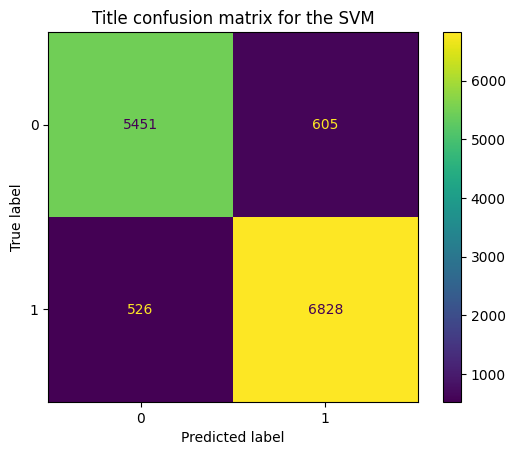

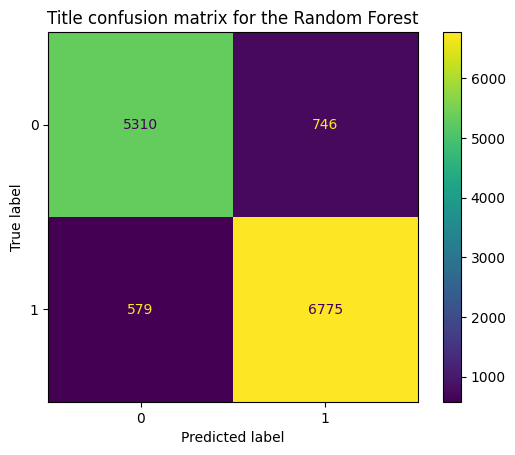

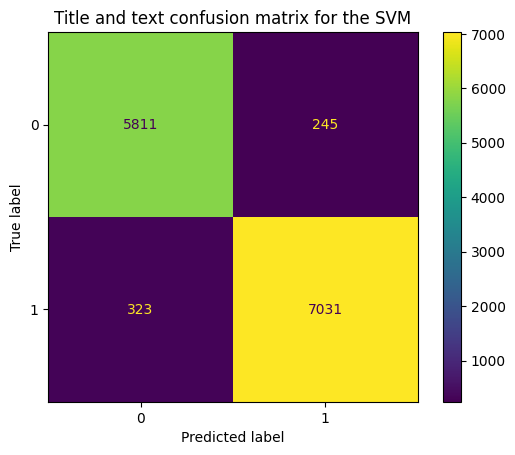

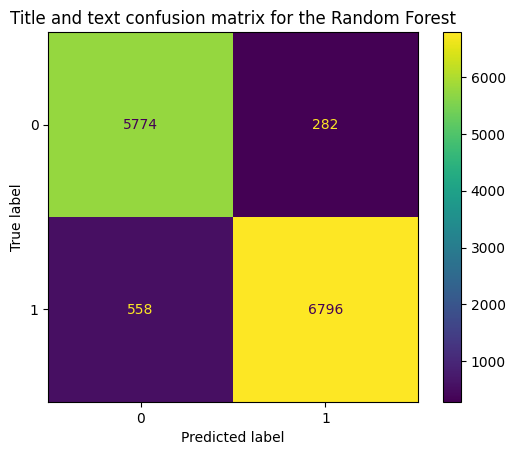

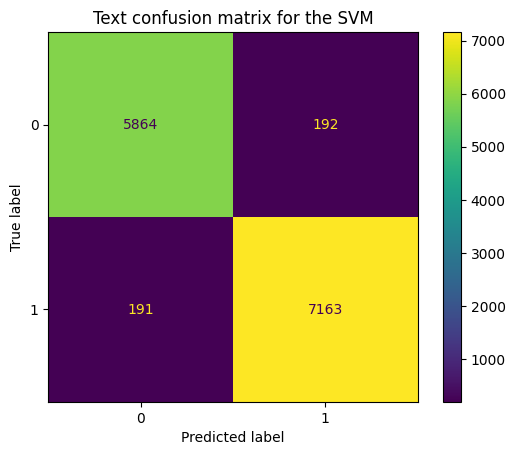

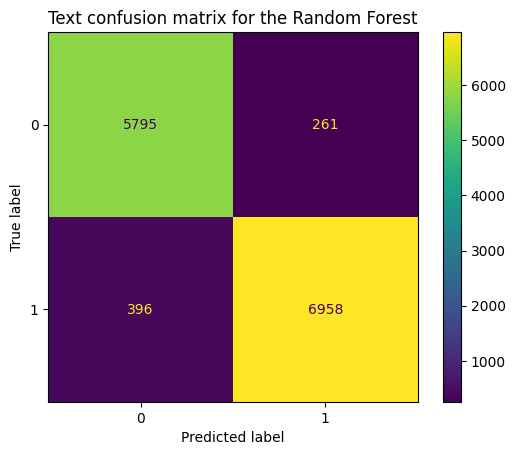

In [49]:
# plot confusion matrix for the title
makeConfMatrix('Title confusion matrix for the SVM', test_y, title_res.svc.iloc[0])
makeConfMatrix('Title confusion matrix for the Random Forest', test_y, title_res.randomforestclassifier.iloc[0])

# plot confusion matrix for the title and text
makeConfMatrix('Title and text confusion matrix for the SVM', test_y, title_text_res.svc.iloc[0])
makeConfMatrix('Title and text confusion matrix for the Random Forest', test_y, title_text_res.randomforestclassifier.iloc[0])

# plot confusion matrix for the text
makeConfMatrix('Text confusion matrix for the SVM', test_y, text_res.svc.iloc[0])
makeConfMatrix('Text confusion matrix for the Random Forest', test_y, text_res.randomforestclassifier.iloc[0])